# Evolutionary conservation analysis

### Import modules

In [1]:
# General
import os
import math
import re
import sys
from glob import glob
from tqdm import tqdm

# Data handling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Statistics
from scipy.stats import ttest_ind

# Machine learning
from sklearn.linear_model import LogisticRegression 


from Bio import pairwise2
from Bio.Seq import Seq 

### Change working directory

In [2]:
os.chdir('/home/amorales/Documents/projects/bias_2')

In [3]:
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'src/utils')
from loaders import load_signaling_df

### Create results folder

In [4]:
# Files generated for this notebook will be stored under results/contacts/
results = "results/evolutionary_conservation_analysis/"
if not os.path.exists(results):
    os.mkdir(results)

## Load Data

### Signaling profile data

In [10]:
# Read signling data
path = 'data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv'
signaling_df = pd.read_csv(path)

# Remove mutations that are not alanin scan
alanin_scan_mask = signaling_df.Mutant.apply(lambda x: bool(re.match('([A-Z])(\d+)$', str(x))))
signaling_df = signaling_df.loc[alanin_scan_mask]

# Remove non usefull columns
cols_of_interst = ['Position','Emax_avg_corr_Gi2_HU210', 'EC50_avg_corr_Gi2_HU210',
                   'Emax_avg_corr_bArr1_HU210', 'EC50_avg_corr_bArr1_HU210']
signaling_df = signaling_df[cols_of_interst]

# Change column names
signaling_df.columns = ['position', 'gi_emax', 'gi_ec50', 'barr_emax', 'barr_ec50']

# Set boolean masks for biased and wt
biased_mask = (signaling_df.barr_emax == 0) & (signaling_df.gi_emax > 0)
wt_mask = (signaling_df.barr_emax > 0) & (signaling_df.gi_emax > 0)

# Create a field wih categorical signal information
signaling_df['profile'] = 2
signaling_df.loc[wt_mask, 'profile'] = 0
signaling_df.loc[biased_mask, 'profile'] = 1


# Remove mutants with other signaling profiles
signaling_df = signaling_df[signaling_df.profile != 2]

In [11]:
signaling_df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile
0,1,0.825515,0.098706,1.122299,0.385988,0
1,2,0.615114,0.468060,0.907206,0.393758,0
2,3,1.072523,-0.109611,0.826491,-0.361701,0
3,4,1.203155,-0.047019,1.060027,-0.022091,0
4,5,1.003370,-0.119622,1.008177,-0.119924,0
...,...,...,...,...,...,...
367,356,1.062682,-0.189900,0.976102,0.130637,0
368,357,1.167825,-0.240117,0.747814,0.007049,0
369,358,1.107844,-0.101797,0.862811,0.468228,0
370,359,1.158079,0.059214,0.744454,-0.265148,0


In [12]:
# Add string labels 
f = lambda x: 'biased' if x else 'wt'
signaling_df['profile_lbl'] = signaling_df.profile.apply(f)

# Convert the residue id into a int column
signaling_df.position = signaling_df.position.astype(int)

In [13]:
signaling_df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile,profile_lbl
0,1,0.825515,0.098706,1.122299,0.385988,0,wt
1,2,0.615114,0.468060,0.907206,0.393758,0,wt
2,3,1.072523,-0.109611,0.826491,-0.361701,0,wt
3,4,1.203155,-0.047019,1.060027,-0.022091,0,wt
4,5,1.003370,-0.119622,1.008177,-0.119924,0,wt
...,...,...,...,...,...,...,...
367,356,1.062682,-0.189900,0.976102,0.130637,0,wt
368,357,1.167825,-0.240117,0.747814,0.007049,0,wt
369,358,1.107844,-0.101797,0.862811,0.468228,0,wt
370,359,1.158079,0.059214,0.744454,-0.265148,0,wt


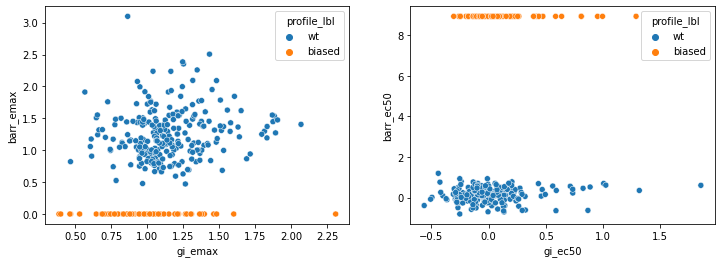

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(data=signaling_df, x='gi_emax', y='barr_emax', hue='profile_lbl')
plt.subplot(1,2,2)
sns.scatterplot(data=signaling_df, x='gi_ec50', y='barr_ec50', hue='profile_lbl')
plt.show()

In [15]:
signaling_df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile,profile_lbl
0,1,0.825515,0.098706,1.122299,0.385988,0,wt
1,2,0.615114,0.468060,0.907206,0.393758,0,wt
2,3,1.072523,-0.109611,0.826491,-0.361701,0,wt
3,4,1.203155,-0.047019,1.060027,-0.022091,0,wt
4,5,1.003370,-0.119622,1.008177,-0.119924,0,wt
...,...,...,...,...,...,...,...
367,356,1.062682,-0.189900,0.976102,0.130637,0,wt
368,357,1.167825,-0.240117,0.747814,0.007049,0,wt
369,358,1.107844,-0.101797,0.862811,0.468228,0,wt
370,359,1.158079,0.059214,0.744454,-0.265148,0,wt


In [16]:
profile_coordinates = signaling_df[['gi_emax', 'gi_ec50', 'barr_emax', 'barr_ec50']]
profile_coordinates = profile_coordinates.fillna(8.94)
profile_coordinates = profile_coordinates.values

In [17]:
emax_distance = np.linalg.norm(profile_coordinates[:,[0,2]] - np.array([1,1]), axis=1)
ec50_distance = np.linalg.norm(profile_coordinates[:,[1,3]] - np.array([0,0]), axis=1)

In [18]:
unaffected_gi_mask = pd.Series((emax_distance < 0.35) & (ec50_distance < 0.35))

In [19]:
affected_gi = unaffected_gi_mask.apply(lambda x:'unaffected' if x else 'affected')

In [20]:
signaling_df['affected_gi'] = affected_gi.values

In [21]:
signaling_df['agg_label'] = signaling_df[['profile_lbl','affected_gi']].aggregate('-'.join, axis=1)

In [22]:
signaling_df['agg_label'] = signaling_df['agg_label'].apply(lambda x: x if 'wt' in x else 'biased')

In [23]:
signaling_df['agg_label'].value_counts()

wt-affected      184
wt-unaffected     66
biased            64
Name: agg_label, dtype: int64

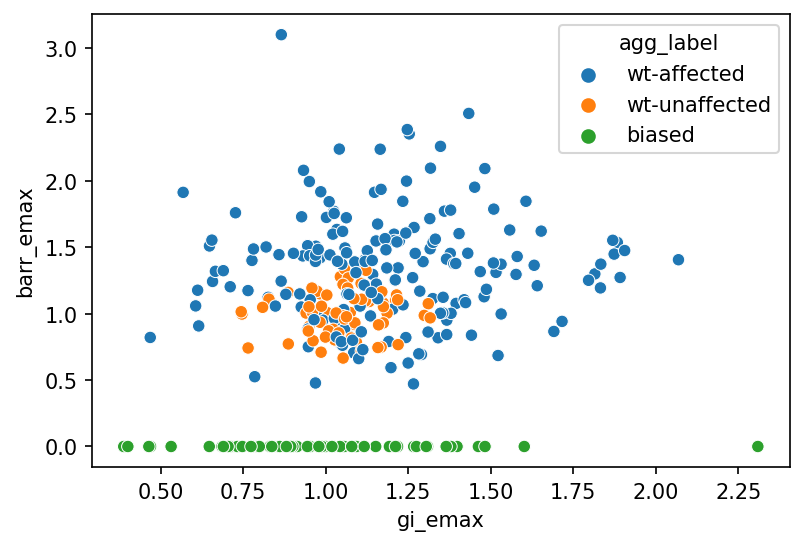

In [24]:
plt.figure(dpi=150)
sns.scatterplot(data=signaling_df, x='gi_emax', y='barr_emax', hue='agg_label')
# plt.axis('equal')
plt.show()

In [25]:
affectation = np.linalg.norm(signaling_df[['gi_emax', 'barr_emax']].values - np.array([1,1]), axis=1)

signaling_df['affectation'] = affectation

### Feature importance data

In [32]:
# Load the contact frequency dataframe
path = 'data/processed/features_new.csv'
df = pd.read_csv(path, index_col=0)

/home/amorales/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



In [33]:
df

,mutant_id,replica,242-246,116-119,166-170,215-240,34-38,127-73,124-205,23-271,...,207-227,16-26,16-33,17-26,16-30,133-226,287-39,285-291,130-135,profile
3,33,4,1.000,0.380,1.000,0.000,0.988,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
4,33,5,1.000,0.565,0.995,0.000,1.000,0.000,0.405,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
5,33,6,1.000,0.463,0.993,0.005,0.995,0.000,0.297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
6,33,7,1.000,0.472,1.000,0.000,0.990,0.018,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
7,33,8,1.000,0.510,0.993,0.260,0.998,0.003,0.305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,wt,4,0.993,0.537,0.998,0.000,1.000,0.472,0.357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.003,0.000,0
249,wt,5,1.000,0.463,0.985,0.000,1.000,0.265,0.378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
250,wt,6,1.000,0.545,1.000,0.138,1.000,0.520,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0
251,wt,7,1.000,0.568,0.990,0.000,1.000,0.347,0.325,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0


In [34]:
simulated_mutants = df.mutant_id.unique()

In [35]:
' '.join([str(m) for m in simulated_mutants])

'33 47 49 52 53 77 91 112 119 121 152 159 165 178 185 203 205 217 251 282 291 293 297 319 109 117 117 125 176 199 285 292 302 313 61 wt'

In [22]:
# Load the contact frequency dataframe
path = 'results/ligand_contacts/freq_df.tsv'
df = pd.read_csv(path, index_col=0)
df.index.name='mutant_id'
df = df.reset_index()
df = df.dropna()
df.mutant_id = df.mutant_id.astype(int)

In [23]:
# Remove high correlated features
max_corr = 0.90

real_corr_matrix = df.drop('mutant_id', axis=1).corr()
abs_corr_matrix = real_corr_matrix.abs()
# Extract the upper trinagule from the correlation matrix
upper = abs_corr_matrix.where(
    np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(np.bool))
# Remove redundant features with a correlation higher than max_corr
to_drop = [column for column in upper.columns if any(upper[column] > max_corr)]
df = df.drop(to_drop, axis=1)

print('droped ', len(to_drop), 'columns, ', len(df.columns) - 3, ' remaining')

/tmp/ipykernel_1108/474888603.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(np.bool))


droped  1060 columns,  2561  remaining


In [24]:
# Create a dictionary holding the 
corr_dict = {}
for col in df.columns[1:]:
    corr_dict[col] = abs_corr_matrix.columns[abs_corr_matrix[col] > max_corr].values

# Removing the own contact from the dictionary and contacts without correlated contacts
for contact, contact_list in corr_dict.items():
     if contact_list.size > 1:
            corr_dict[contact] = [c for c in contact_list if c != contact]

In [25]:
# Create the dataframe and separete features from labels
df = pd.merge(signaling_df, df, left_on='position', right_on="mutant_id")

y = df.profile
X = df[[col for col in df.columns if '-' in col]]

In [26]:
# Create and fit the model
C = 0.001
lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=C)
lr.fit(X, y)

LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000)

In [28]:
for C in np.logspace(0, -3, 10):
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, C=C)
    lr.fit(X, y)
    real_score = lr.score(X, y)
    print(real_score)
    rlr = LogisticRegression(class_weight='balanced', max_iter=1000, C=C)

    random_score = []
    for i in tqdm(range(1000)):
        r_y = np.random.permutation(y)
        rlr.fit(X, r_y)
        random_score.append(rlr.score(X, r_y))
    
    
    sns.histplot(random_score)
    plt.title(f'C: {C:.3f}')
    plt.axvline(real_score, color='red')
    plt.show()

1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
coef_df = pd.DataFrame({'contact': X.columns, 'coef': lr.coef_.flatten()})

coef_df

,contact,coef
0,146-149,2.974499e-04
1,109-111,4.722614e-07
2,91-93,6.013249e-05
3,173-174,8.567788e-05
4,46-50,4.789138e-05
...,...,...
2558,172-19,-1.801458e-06
2559,292-77,-8.996312e-07
2560,132-221,-8.966827e-07
2561,59-74,-1.812248e-06


In [ ]:
# Add the correlated contacts with the same coefficient than their representer
for contact, corr_list in corr_dict.items():
    # extract the coefficient
    coef = coef_df[coef_df.contact == contact].coef.values[0]
    # Create the new rows
    corr_rows = pd.DataFrame({'contact': corr_list, 'coef': coef})
    # Append them to the coef_df
    coef_df = pd.concat([coef_df, corr_rows])

In [ ]:
coef_df['abs_coef'] = coef_df.coef.abs()

coef_df = coef_df.drop(['coef'], axis=1)

coef_df[['r1', 'r2']] = coef_df.contact.str.split('-', expand=True)

coef_df = coef_df.drop(['contact'], axis=1)

coef_df = coef_df.melt(id_vars='abs_coef', value_vars=['r1', 'r2']).drop('variable', axis=1)

agg_coef_df = coef_df.groupby('value').abs_coef.mean().reset_index()

agg_coef_df['max_coef'] = coef_df.groupby('value').abs_coef.max().reset_index().abs_coef.values

agg_coef_df['sum_coef'] = coef_df.groupby('value').abs_coef.sum().reset_index().abs_coef.values

agg_coef_df['min_coef'] = coef_df.groupby('value').abs_coef.min().reset_index().abs_coef.values

coef_df = agg_coef_df

coef_df = coef_df[coef_df.value != 'LIG']

coef_df.value = coef_df.value.astype(int)

/home/amorales/anaconda3/envs/bias/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
coef_df

,value,abs_coef,max_coef,sum_coef,min_coef
0,100,0.000738,0.002655,0.036184,4.695187e-07
1,101,0.000731,0.001918,0.040957,4.722614e-07
2,102,0.000354,0.001723,0.013449,4.695187e-07
3,103,0.000181,0.000754,0.011427,3.008435e-07
4,104,0.000266,0.001016,0.006644,1.144468e-06
...,...,...,...,...,...
284,95,0.000893,0.002578,0.063404,1.562338e-06
285,96,0.000467,0.003970,0.021501,4.714790e-07
286,97,0.000522,0.002715,0.025571,4.695187e-07
287,98,0.000911,0.005291,0.054686,4.722614e-07


In [ ]:
coef_df.sort_values('abs_coef', ascending=False)

,value,abs_coef,max_coef,sum_coef,min_coef
134,240,0.001176,0.007201,0.090550,4.889993e-07
135,241,0.001043,0.004441,0.051109,2.628229e-06
130,237,0.001009,0.007201,0.087749,4.889993e-07
197,298,0.001008,0.004303,0.032259,1.661093e-06
202,302,0.000915,0.005935,0.054914,7.260536e-07
...,...,...,...,...,...
59,159,0.000039,0.000252,0.000627,1.363252e-06
147,252,0.000039,0.000209,0.000783,4.719972e-07
102,200,0.000027,0.000125,0.000437,1.024089e-06
62,162,0.000026,0.000314,0.000502,7.982572e-07


### Conservation Scores

#### Class A alignment

In [28]:
def get_conservation_df(basename):   
    
    # Load alignment dataframe
    alignment_df = pd.read_csv(f"data/raw/{basename}_gpcr_alignment.csv", index_col=0, header=1)
    
    # Extract the alignment of the cb2
    cb2_alignment = alignment_df.loc['[Human] CB2 receptor'].values
    
    # Extract the sequence without gaps
    alignment_cb2_seq = ''.join([res for res in cb2_alignment if res not in  ['_', '-']])
    
    # Get the sequence from uniprot
    uniprot_cb2_sequence = 'MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLLSALENVAVLYLILSSH'\
    'QLRRKPSYLFIGSLAGADFLASVVFACSFVNFHVFHGVDSKAVFLLKIGSVTMTFTASVGSLLLTAIDRYLCLRYPPSYKALLTRGRAL'\
    'VTLGIMWVLSALVSYLPLMGWTCCPRPCSELFPLIPNDYLLSWLLFIAFLFSGIIYTYGHVLWKAHQHVASLSGHQDRQVPGMARMRLD'\
    'VRLAKTLGLVLAVLLICWFPVLALMAHSLATTLSDQVKKAFAFCSMLCLINSMVNPVIYALRSGEIRSSAHHCLAHWKKCVRGLGSEAK'\
    'EEAPRSSVTETEADGKITPWPDSRDLDLSDC'
    
    seq1 = Seq(alignment_cb2_seq) 
    seq2 = Seq(uniprot_cb2_sequence)
    alignments = pairwise2.align.globalms(seq1, seq2, 2, -1, -2, -1)
    al = alignments[0].seqA
    uni = alignments[0].seqB
    
#     print(al)
#     print(uni)
    
    equivalence = []
    for resid, (a, b) in enumerate(zip(al, uni), 1):
        if a != '-':
            equivalence.append(resid)
#     print(equivalence)
    # Loading conservation scores
    conservation_scores = []

    with open(f"data/raw/{basename}_conservation_scores.txt") as file:
        for line in file:
            if re.match('\d', line):
                conservation_scores.append(float(line.split('\t')[1]))
                
    res_mask = [True if not char in ['_', '-'] else False for char in cb2_alignment]
    conservation_scores = np.array(conservation_scores)[res_mask]
    order_resid_df = []
    for resid, score in zip(equivalence, conservation_scores):  
        order_resid_df.append([score, resid])

    order_resid_df = pd.DataFrame(order_resid_df, columns=[f'{basename}_score', 'resid'])
    order_resid_df = order_resid_df.dropna()
    
    return order_resid_df

In [29]:
class_a_conservation_df = get_conservation_df('class_a')
class_a_conservation_df

,class_a_score,resid
0,0.04546,29
1,0.04888,30
2,0.06530,31
3,0.05891,32
4,0.07116,33
...,...,...
251,0.12506,315
252,0.09567,316
253,0.07678,317
254,0.05014,318


In [30]:
class_a_conservation_df.describe()

,class_a_score,resid
count,256.000000,256.000000
mean,0.251696,172.128906
std,0.124827,87.512839
min,0.038520,29.000000
25%,0.159108,93.750000
50%,0.237940,162.500000
75%,0.328575,253.250000
max,0.620860,319.000000


In [41]:
simulated_mutants = [int(m) for m in simulated_mutants if m != 'wt']

In [42]:
class_a_conservation_df[class_a_conservation_df.resid.isin(simulated_mutants)].describe()

,class_a_score,resid
count,31.000000,31.000000
mean,0.279692,173.903226
std,0.114126,96.331495
min,0.038960,33.000000
25%,0.203230,100.000000
50%,0.299540,159.000000
75%,0.349885,283.500000
max,0.465310,319.000000


In [76]:
import MDAnalysis as mda

u = mda.Universe('data/raw/cb2_inactive.pdb')

In [77]:
score = class_a_conservation_df.class_a_score.values

In [78]:
score = (score-score.min()) / (score.max()-score.min())

<AxesSubplot:ylabel='Count'>

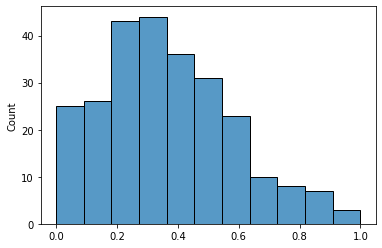

In [79]:
sns.histplot(score)

In [80]:
resids = class_a_conservation_df.resid.astype(int)

In [81]:
d = dict(zip(resids, score))

In [82]:
for res in u.residues:
    resid = res.resid
    b_factor =  d.get(resid, 0)
    for atom in res.atoms:
        atom.bfactor = b_factor

/home/amorales/.virtualenvs/bias/lib64/python3.6/site-packages/MDAnalysis/core/topologyattrs.py:282: DeprecationWarning:

The bfactor topology attribute is only provided as an alias to the tempfactor attribute. It will be removed in 3.0. Please use the tempfactor attribute instead.



In [83]:
u.select_atoms('resid 1:999').write('results/evolutionary_conservation_analysis/receptor_conservation.pdb')

In [84]:
crystalized_residues = set([res.resid for res in u.residues if res.resid < 1000])

In [85]:
res_with_conservation = set(class_a_conservation_df.resid)

In [86]:
' '.join([str(i) for i in simulated_mutants])

'33 47 49 52 53 77 91 112 119 121 152 159 165 178 185 203 205 217 251 282 291 293 297 319 109 117 117 125 176 199 285 292 302 313 61'

In [87]:
' '.join([str(i) for i in crystalized_residues - res_with_conservation])

'272 273 19 20 21 22 23 24 25 26 27 28 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 66 97 98 99 100 101 235 236 237'

In [88]:
' '.join([str(i) for i in res_with_conservation])

'29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319'

#### Class A alanine score

In [89]:
alignment = pd.read_csv('data/raw/class_a_gpcr_alignment.csv', header=1, index_col=0)

In [90]:
alanin_prob = (alignment == 'A').mean().reset_index()

In [91]:
cb2_alignment = alignment.loc['[Human] CB2 receptor'].values
res_mask = [True if not char in ['_', '-'] else False for char in cb2_alignment]

In [92]:
alanin_prob = alanin_prob[res_mask]

In [93]:
alanin_prob['index'] = class_a_conservation_df.resid.values

In [94]:
alanin_prob.columns = ['resid', 'alanin_score']

In [95]:
alanin_prob

,resid,alanin_score
8,29,0.013793
9,30,0.062069
10,31,0.082759
11,32,0.082759
12,33,0.124138
...,...,...
368,315,0.024138
369,316,0.034483
370,317,0.013793
371,318,0.006897


#### Lipidic alignment

In [96]:
lipidic_conservation_df = get_conservation_df('lipidic')
lipidic_conservation_df

,lipidic_score,resid
0,0.13975,1
1,0.16218,2
2,0.15832,3
3,0.16657,4
4,0.15686,5
...,...,...
355,0.17770,356
356,0.19308,357
357,0.19762,358
358,0.20443,359


In [97]:
conservation_df = pd.merge(left=class_a_conservation_df, right=alanin_prob,
                           left_on='resid', right_on='resid')

conservation_df = pd.merge(left=conservation_df, right=lipidic_conservation_df,
                           left_on='resid', right_on='resid')

In [98]:
conservation_df

,class_a_score,resid,alanin_score,lipidic_score
0,0.04546,29,0.013793,0.12263
1,0.04888,30,0.062069,0.14737
2,0.06530,31,0.082759,0.16487
3,0.05891,32,0.082759,0.16710
4,0.07116,33,0.124138,0.18397
...,...,...,...,...
251,0.12506,315,0.024138,0.24217
252,0.09567,316,0.034483,0.21467
253,0.07678,317,0.013793,0.16433
254,0.05014,318,0.006897,0.12269


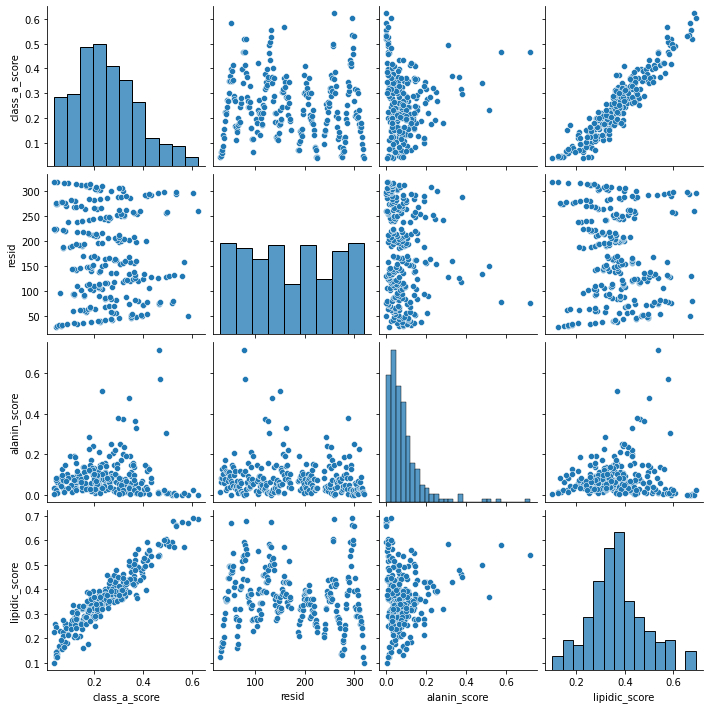

In [99]:
sns.pairplot(conservation_df)
plt.show()

### Merge dataframes

In [100]:
df = pd.merge(signaling_df, conservation_df, left_on='position', right_on='resid')

In [101]:
df = df.drop(['profile', 'resid'], axis=1)

In [102]:
df = pd.merge(df, coef_df, left_on='position', right_on='value', how='left')

NameError: name 'coef_df' is not defined

In [103]:
df = df.drop('value', axis=1)

KeyError: "['value'] not found in axis"

In [104]:
df = df.fillna(0)

In [105]:
df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile_lbl,affected_gi,agg_label,affectation,class_a_score,alanin_score,lipidic_score
0,29,1.377266,-0.080726,1.453091,0.204319,wt,affected,wt-affected,0.589594,0.04546,0.013793,0.12263
1,30,1.057022,-0.067825,1.336484,0.075457,wt,unaffected,wt-unaffected,0.341282,0.04888,0.062069,0.14737
2,31,1.131454,0.147191,1.090715,-0.039388,wt,unaffected,wt-unaffected,0.159717,0.06530,0.082759,0.16487
3,32,1.430271,-0.130197,1.454057,0.259686,wt,affected,wt-affected,0.625541,0.05891,0.082759,0.16710
4,33,1.045174,-0.112751,0.945484,0.555771,wt,affected,wt-affected,0.070801,0.07116,0.124138,0.18397
...,...,...,...,...,...,...,...,...,...,...,...,...
209,315,1.284922,-0.033109,1.169000,0.396290,wt,affected,wt-affected,0.331273,0.12506,0.024138,0.24217
210,316,1.215658,-0.287555,1.539277,0.171420,wt,affected,wt-affected,0.580800,0.09567,0.034483,0.21467
211,317,1.364871,-0.056020,0.000000,8.942628,biased,affected,biased,1.064486,0.07678,0.013793,0.16433
212,318,1.190868,-0.137452,0.790245,-0.354252,wt,affected,wt-affected,0.283598,0.05014,0.006897,0.12269


## Conservation-profile analysis

In [106]:
df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile_lbl,affected_gi,agg_label,affectation,class_a_score,alanin_score,lipidic_score
0,29,1.377266,-0.080726,1.453091,0.204319,wt,affected,wt-affected,0.589594,0.04546,0.013793,0.12263
1,30,1.057022,-0.067825,1.336484,0.075457,wt,unaffected,wt-unaffected,0.341282,0.04888,0.062069,0.14737
2,31,1.131454,0.147191,1.090715,-0.039388,wt,unaffected,wt-unaffected,0.159717,0.06530,0.082759,0.16487
3,32,1.430271,-0.130197,1.454057,0.259686,wt,affected,wt-affected,0.625541,0.05891,0.082759,0.16710
4,33,1.045174,-0.112751,0.945484,0.555771,wt,affected,wt-affected,0.070801,0.07116,0.124138,0.18397
...,...,...,...,...,...,...,...,...,...,...,...,...
209,315,1.284922,-0.033109,1.169000,0.396290,wt,affected,wt-affected,0.331273,0.12506,0.024138,0.24217
210,316,1.215658,-0.287555,1.539277,0.171420,wt,affected,wt-affected,0.580800,0.09567,0.034483,0.21467
211,317,1.364871,-0.056020,0.000000,8.942628,biased,affected,biased,1.064486,0.07678,0.013793,0.16433
212,318,1.190868,-0.137452,0.790245,-0.354252,wt,affected,wt-affected,0.283598,0.05014,0.006897,0.12269


In [107]:
def perm_mean_dif(a, b):
    
    real_dif = a.mean()-b.mean()

    ab = np.concatenate([a, b])

    len_a = a.size

    null_difs = []
    for i in range(1000):
        ab = np.random.permutation(ab)

        a = ab[:len_a]
        b = ab[len_a:]

        mean_dif = a.mean()-b.mean()
        null_difs.append(mean_dif)

    null_difs = np.array(null_difs)

    p_value = (null_difs < real_dif).mean()
    
    
    return p_value

In [108]:
sns.color_palette()[:4]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

In [109]:
def score_distribution_analysis(score):


    plt.figure(dpi=300)
    temp_df = df[df.agg_label != 'wt-affected']
#     temp_df = df
    sns.kdeplot(data=temp_df, x=score, hue='agg_label', common_norm=False)
#     plt.legend(title='Signaling profile', labels=['biased', 'wt'])

    for l, c in zip(temp_df.agg_label.unique(), sns.color_palette()):
        s = temp_df[temp_df.agg_label == l][score].values
        plt.axvline(s.mean(), color=c)
        
    wt_scores = df[df.agg_label == 'wt-unaffected'][score].values
    bias_scores = df[df.profile_lbl == 'biased'][score].values
    
    mean_dif = wt_scores.mean()-bias_scores.mean()
    ttest_pval = ttest_ind(wt_scores, bias_scores).pvalue
    perm_pval = perm_mean_dif(wt_scores, bias_scores)
    
    
    print(f"Mean difference: {mean_dif:.3f}")
    print(f"T-test p value: {ttest_pval:.3f}")
    print(f"permutation test p value: {perm_pval:.3f}")

<AxesSubplot:xlabel='class_a_score', ylabel='affectation'>

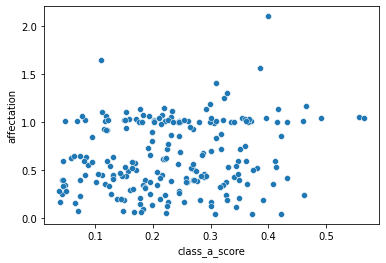

In [110]:
sns.scatterplot(data=df, x='class_a_score', y='affectation')

Mean difference: -0.054
T-test p value: 0.061
permutation test p value: 0.025


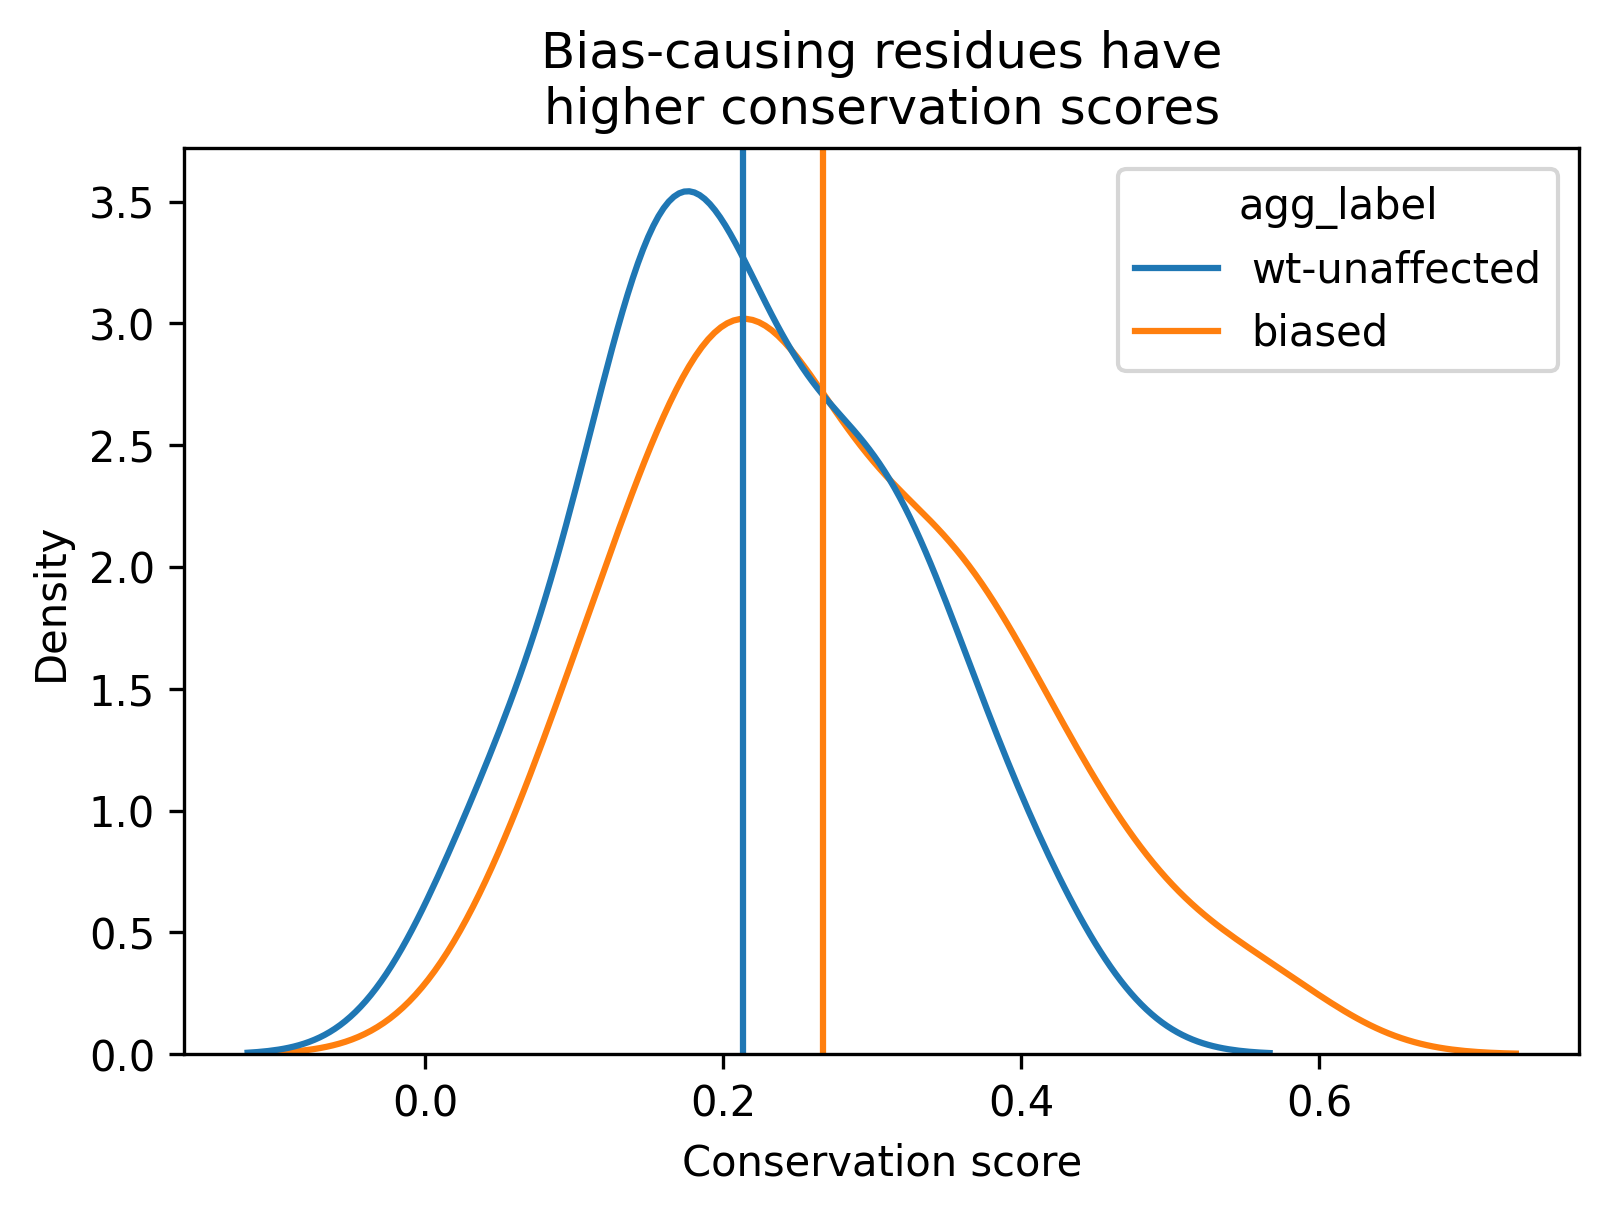

In [111]:
score_distribution_analysis('class_a_score')
plt.xlabel('Conservation score')
plt.title('Bias-causing residues have\nhigher conservation scores')
plt.show()

Mean difference: 0.013
T-test p value: 0.564
permutation test p value: 0.729


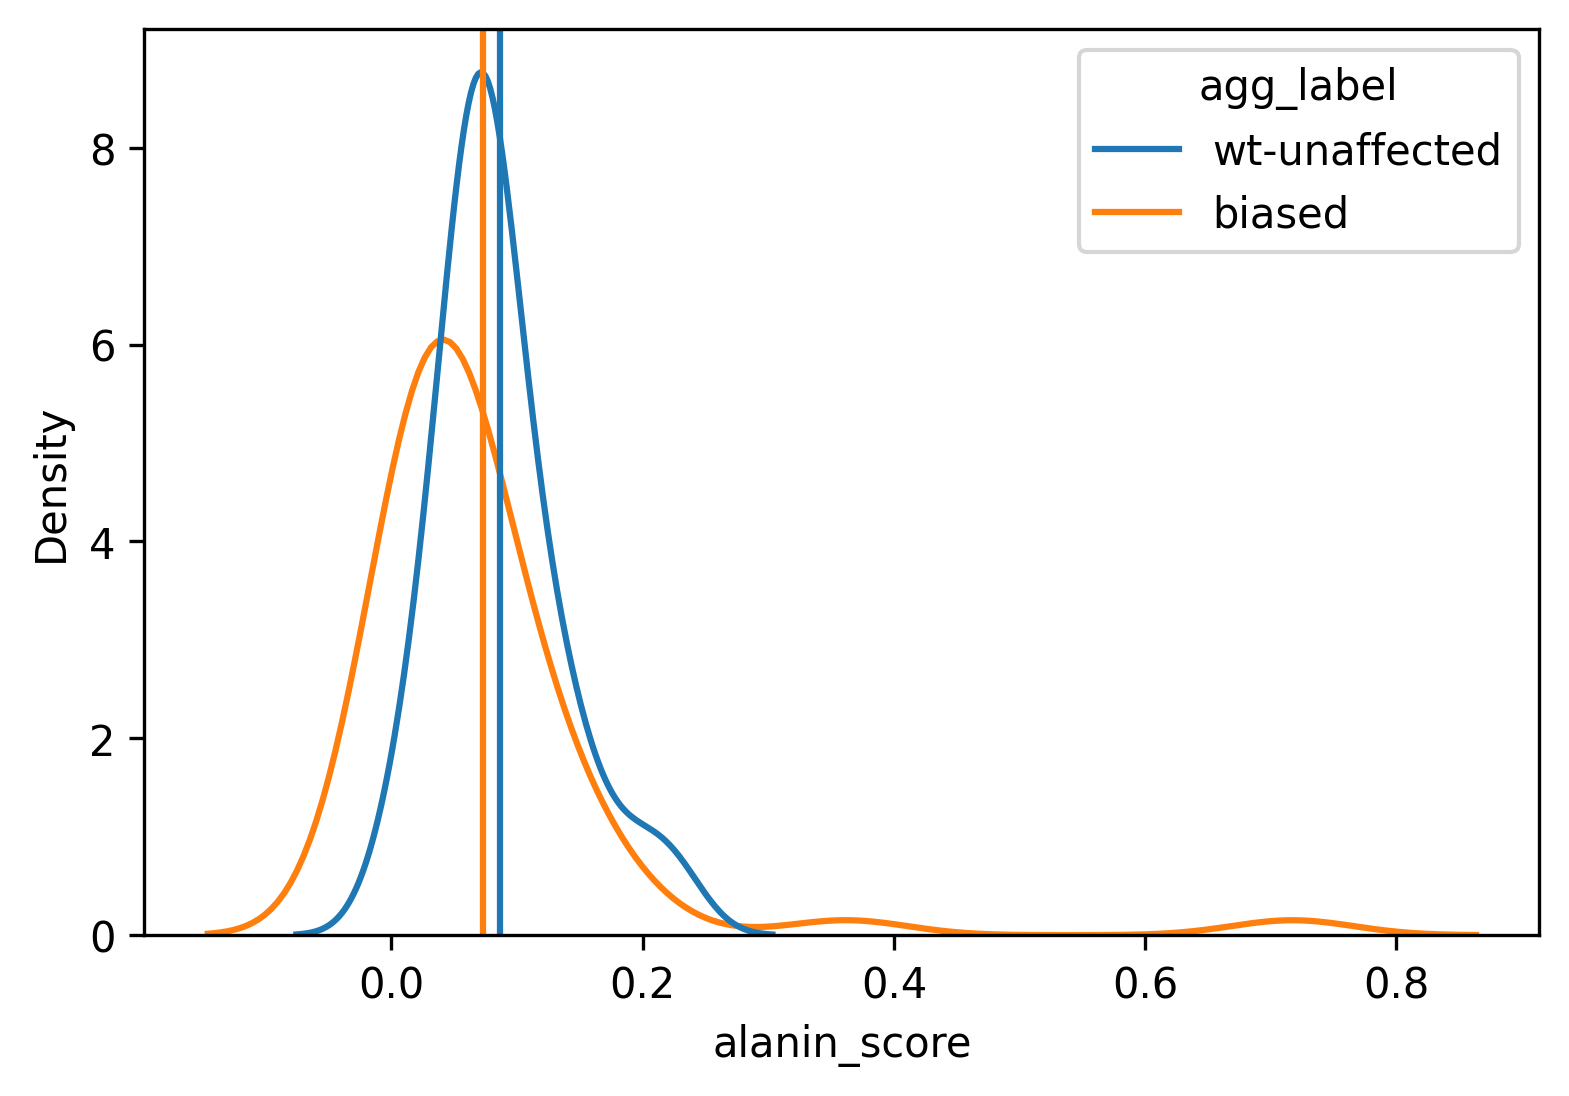

In [112]:
score_distribution_analysis('alanin_score')

Mean difference: -0.060
T-test p value: 0.030
permutation test p value: 0.019


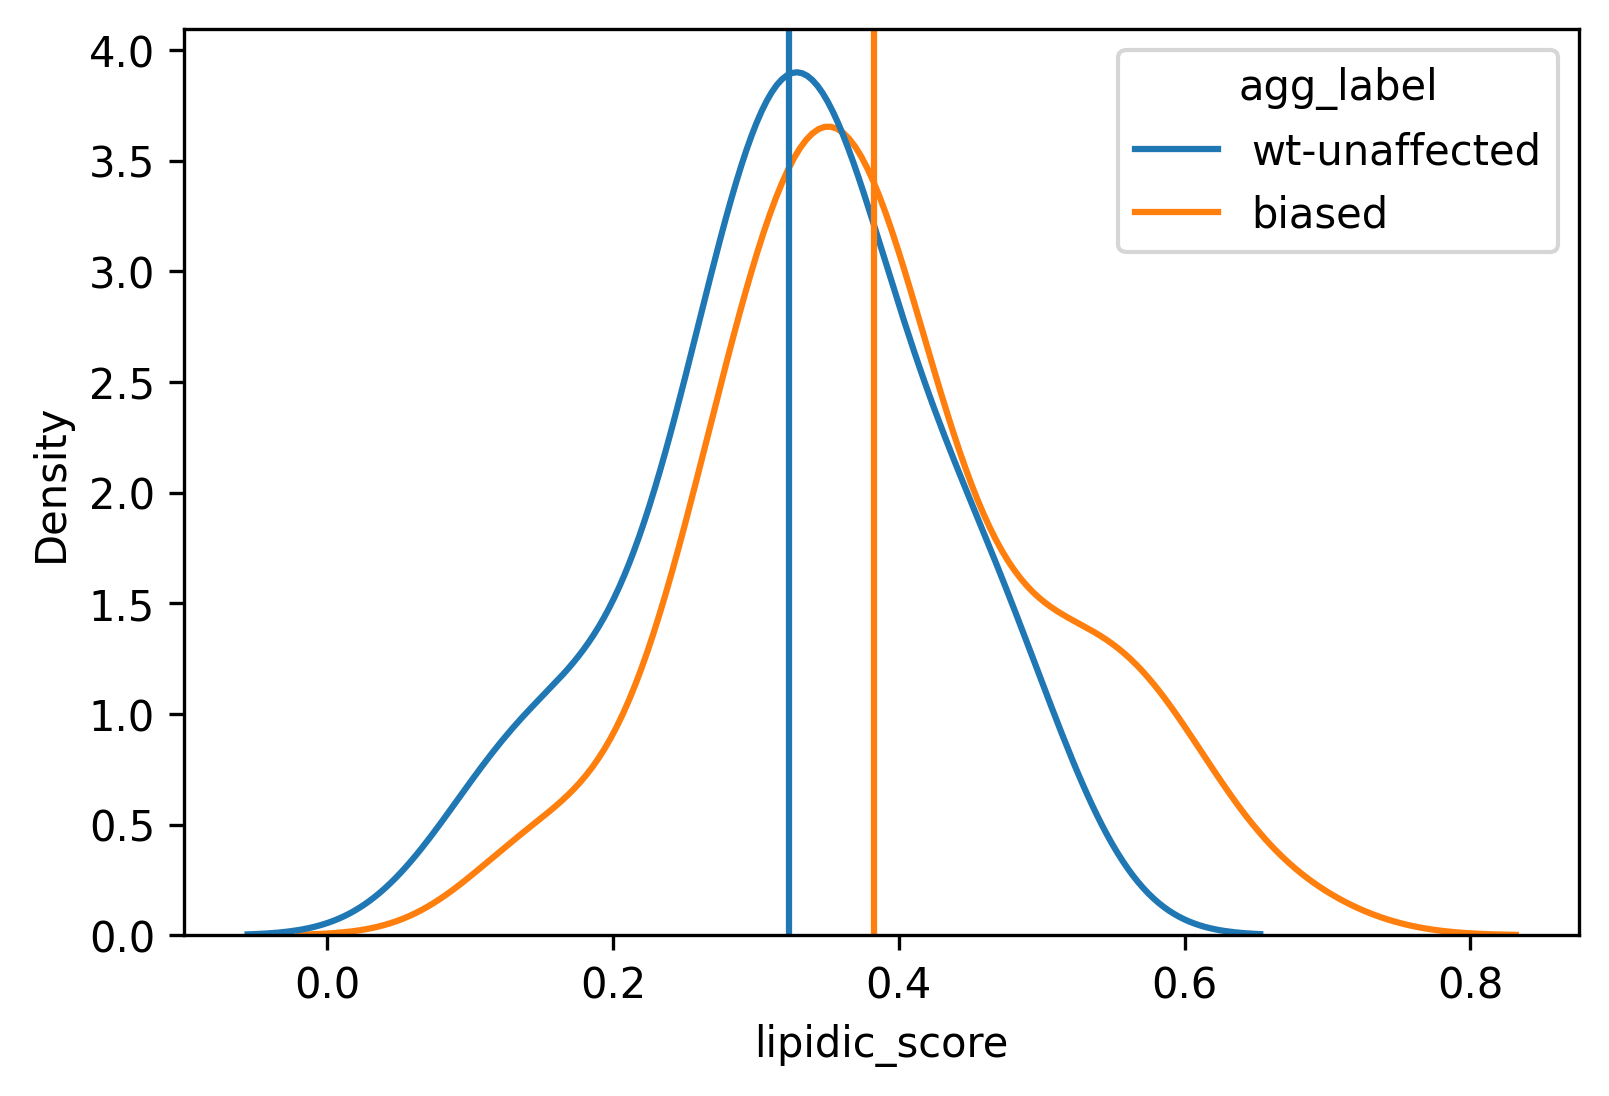

In [113]:
score_distribution_analysis('lipidic_score')

In [114]:
def plot_biased_percentage_score(score, n=None):
    temp_df = df
#     temp_df = df[df.agg_label != 'wt-affected']
    sorted_df = temp_df.sort_values(score, ascending=False)
    
    count_list = []
    for i in range(1, sorted_df.shape[0]+1):
        counts = sorted_df.agg_label[:i].value_counts()
        count_list.append(counts)
        
    counts_df = pd.concat(count_list, axis=1).transpose().fillna(0)
    
    # Normalize counts
    counts_df = counts_df.div(counts_df.sum(axis=1), axis=0).reset_index(drop=True).reset_index()
    
    counts_df[score] = sorted_df[score].values
    
    sns.lineplot(data=counts_df[:n], x=score, y='biased')
    plt.xlabel('Conservation score threshold')
    plt.ylabel('Ratio of bias-causing residues')
    plt.show()

In [115]:
def plot_biased_percentage(score, n=None):
    temp_df = df
#     temp_df = df[df.agg_label != 'wt-affected']
    sorted_df = temp_df.sort_values(score, ascending=False)
    
    count_list = []
    for i in range(1, sorted_df.shape[0]+1):
        counts = sorted_df.agg_label[:i].value_counts()
        count_list.append(counts)
        
    counts_df = pd.concat(count_list, axis=1).transpose().fillna(0)
    
    # Normalize counts
    counts_df = counts_df.div(counts_df.sum(axis=1), axis=0).iloc[1:].reset_index(drop=True).reset_index()
    
    sns.lineplot(data=counts_df[:n], x='index', y='biased')
    plt.xlabel('N residues considered')
    plt.ylabel('Ratio of bias-causing residues')
    plt.show()

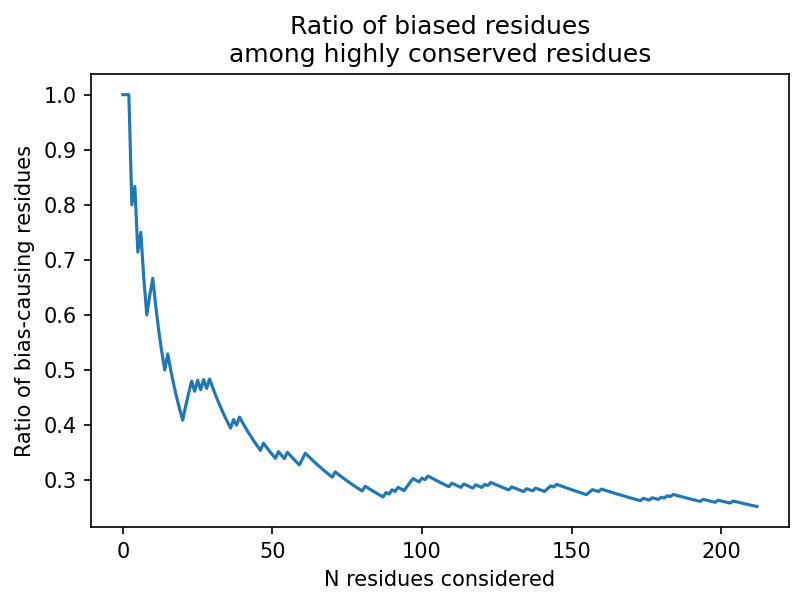

In [116]:
plt.figure(dpi=150)
plt.title('Ratio of biased residues\namong highly conserved residues')
plot_biased_percentage('class_a_score')

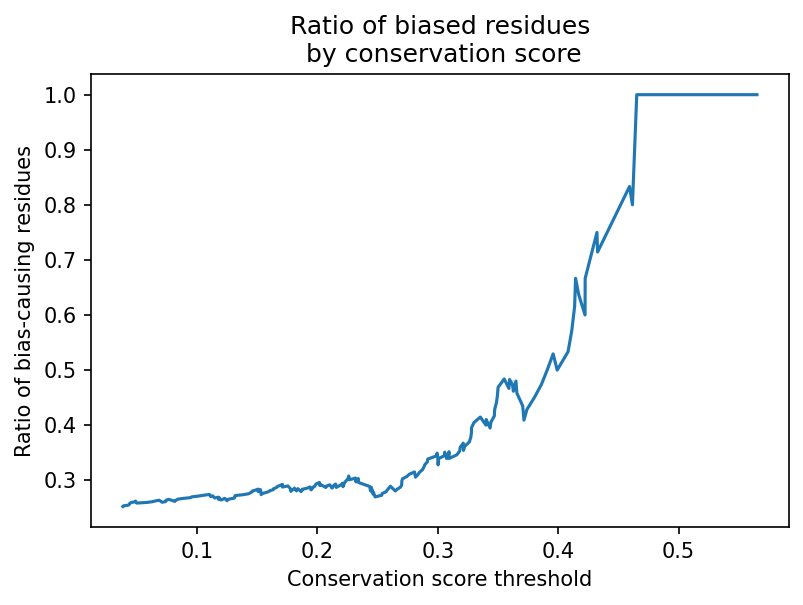

In [117]:
plt.figure(dpi=150)
plt.title('Ratio of biased residues\n by conservation score')
plot_biased_percentage_score('class_a_score')

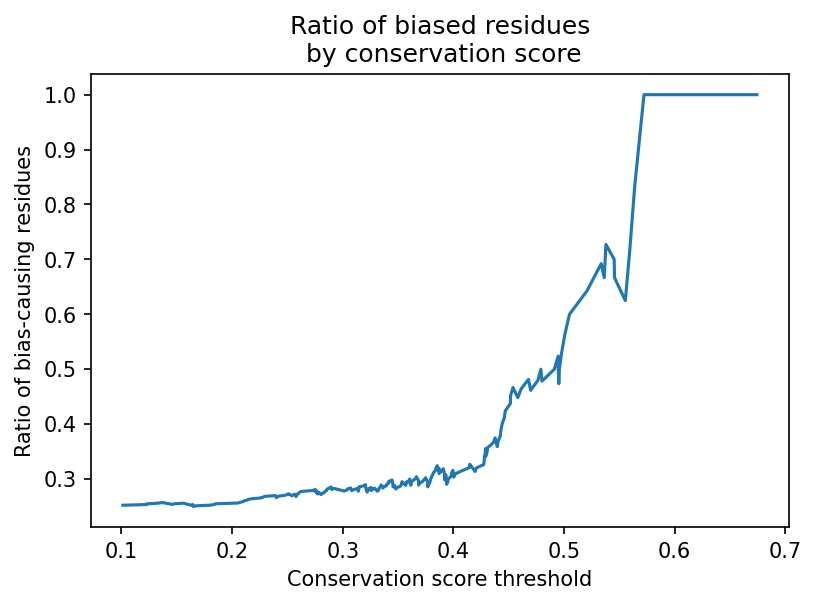

In [118]:
plt.figure(dpi=150)
plt.title('Ratio of biased residues\n by conservation score')
plot_biased_percentage_score('lipidic_score')

In [119]:
df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile_lbl,affected_gi,agg_label,affectation,class_a_score,alanin_score,lipidic_score
0,29,1.377266,-0.080726,1.453091,0.204319,wt,affected,wt-affected,0.589594,0.04546,0.013793,0.12263
1,30,1.057022,-0.067825,1.336484,0.075457,wt,unaffected,wt-unaffected,0.341282,0.04888,0.062069,0.14737
2,31,1.131454,0.147191,1.090715,-0.039388,wt,unaffected,wt-unaffected,0.159717,0.06530,0.082759,0.16487
3,32,1.430271,-0.130197,1.454057,0.259686,wt,affected,wt-affected,0.625541,0.05891,0.082759,0.16710
4,33,1.045174,-0.112751,0.945484,0.555771,wt,affected,wt-affected,0.070801,0.07116,0.124138,0.18397
...,...,...,...,...,...,...,...,...,...,...,...,...
209,315,1.284922,-0.033109,1.169000,0.396290,wt,affected,wt-affected,0.331273,0.12506,0.024138,0.24217
210,316,1.215658,-0.287555,1.539277,0.171420,wt,affected,wt-affected,0.580800,0.09567,0.034483,0.21467
211,317,1.364871,-0.056020,0.000000,8.942628,biased,affected,biased,1.064486,0.07678,0.013793,0.16433
212,318,1.190868,-0.137452,0.790245,-0.354252,wt,affected,wt-affected,0.283598,0.05014,0.006897,0.12269


In [120]:
counts_df.describe()

NameError: name 'counts_df' is not defined

In [121]:
simulated_df = df[df.position.isin(simulated_mutants)]

In [122]:
simulated_df[['position', 'profile_lbl', 'class_a_score']].to_csv('results/evolutionary_conservation_analysis/simulated_conservations.csv')

In [123]:
simulated_df[['position', 'profile_lbl', 'class_a_score']]

,position,profile_lbl,class_a_score
4,33,wt,0.07116
17,47,wt,0.34963
19,49,wt,0.34881
21,52,wt,0.35014
22,53,wt,0.39091
29,61,biased,0.11306
38,77,biased,0.46531
49,91,wt,0.21983
61,109,biased,0.21524
63,112,wt,0.22135


In [124]:
for i, row in simulated_df.iterrows():
    resid = row.position
    size = (row.class_a_score-simulated_df.class_a_score.min())/(simulated_df.class_a_score.max() - simulated_df.class_a_score.min()) + 0.5
    profile = row.profile_lbl
    color = 0 if profile == 'wt' else 3
    
    print(f"""mol color ColorID {color}
    mol representation VDW {size} 24
    mol selection resid {resid} and name CA
    mol material AOChalky
    mol addrep top""")

mol color ColorID 0
    mol representation VDW 0.575524803565146 24
    mol selection resid 33 and name CA
    mol material AOChalky
    mol addrep top
mol color ColorID 0
    mol representation VDW 1.2286736249560222 24
    mol selection resid 47 and name CA
    mol material AOChalky
    mol addrep top
mol color ColorID 0
    mol representation VDW 1.226750322504984 24
    mol selection resid 49 and name CA
    mol material AOChalky
    mol addrep top
mol color ColorID 0
    mol representation VDW 1.229869825260936 24
    mol selection resid 52 and name CA
    mol material AOChalky
    mol addrep top
mol color ColorID 0
    mol representation VDW 1.3254954849302216 24
    mol selection resid 53 and name CA
    mol material AOChalky
    mol addrep top
mol color ColorID 3
    mol representation VDW 0.6738008678315938 24
    mol selection resid 61 and name CA
    mol material AOChalky
    mol addrep top
mol color ColorID 3
    mol representation VDW 1.5 24
    mol selection resid 77 and 

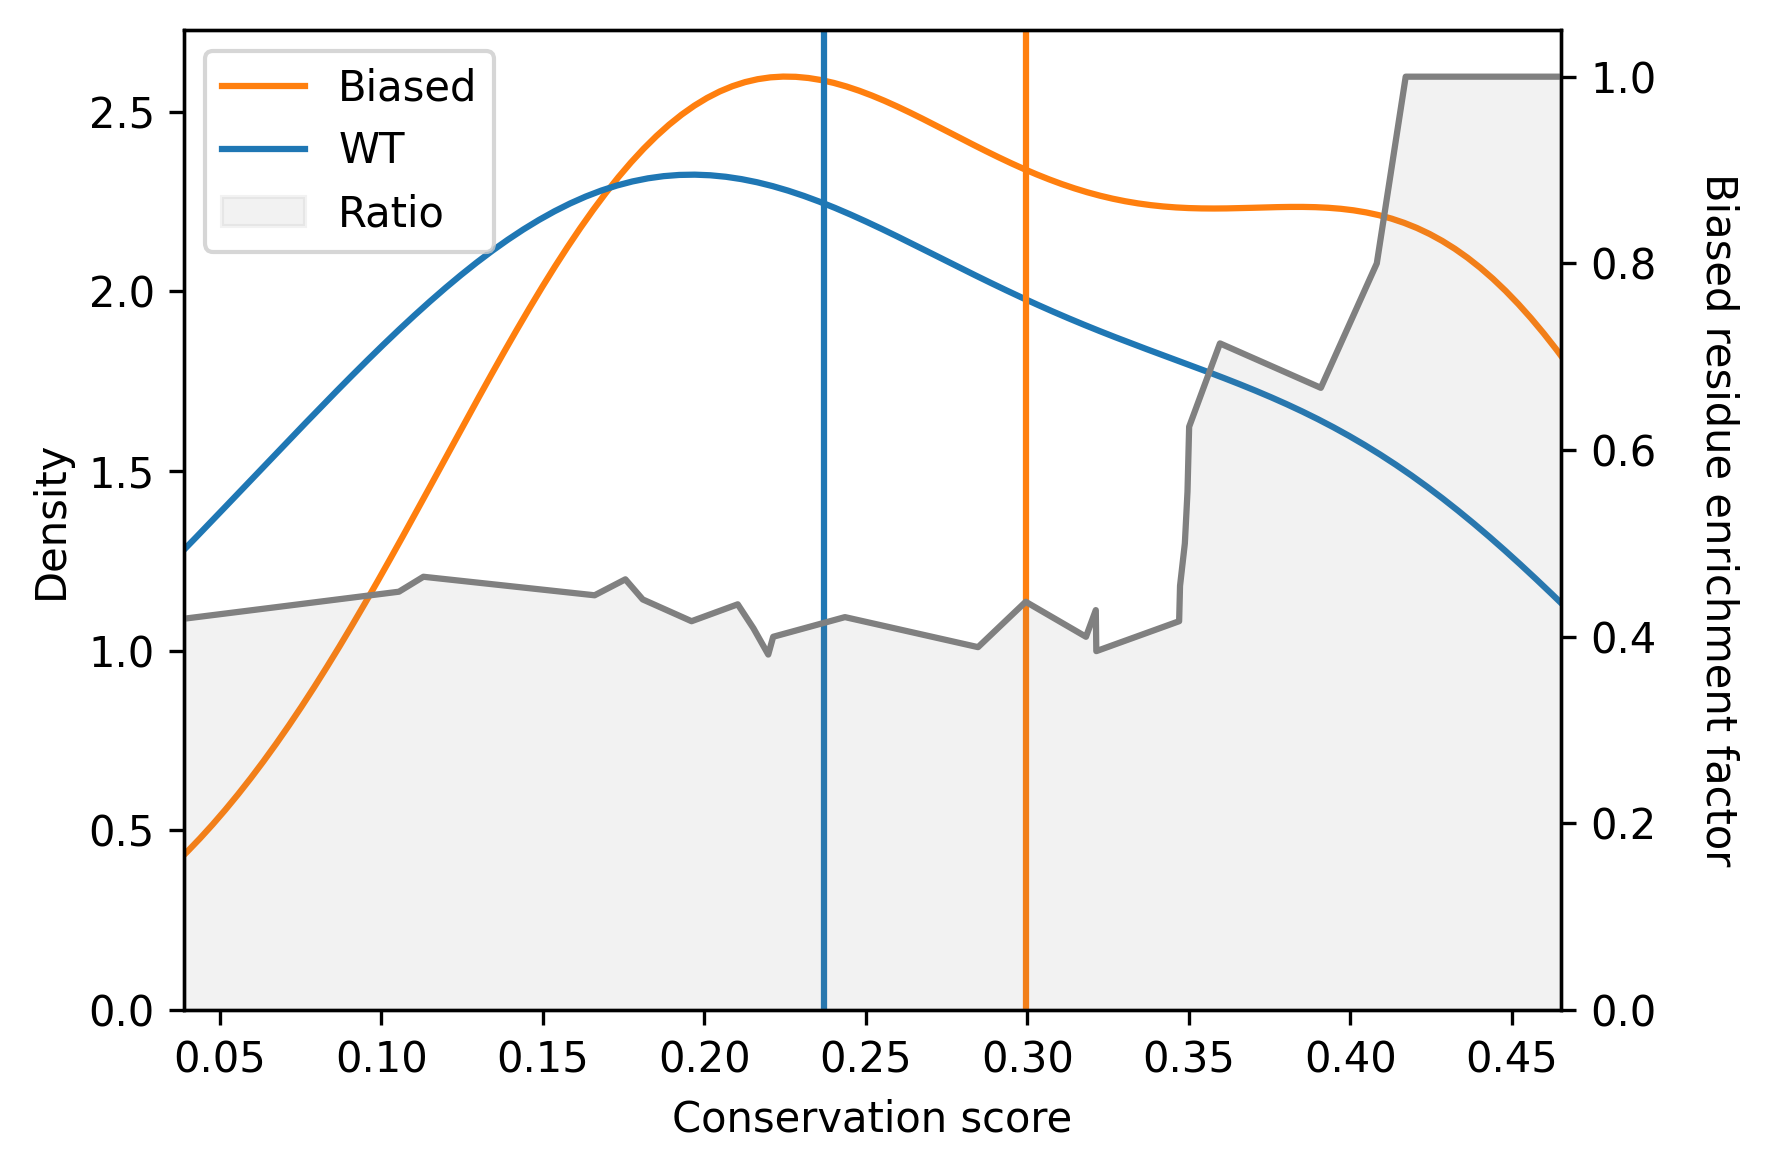

In [125]:
score = 'class_a_score'

fig, ax = plt.subplots(dpi=300)
# temp_df = df[df.agg_label != 'wt-affected']
temp_df = simulated_df[simulated_df.agg_label != 'wt-affected']

#     temp_df = df
sns.kdeplot(data=temp_df, x=score, hue='agg_label', common_norm=False)
#     plt.legend(title='Signaling profile', labels=['biased', 'wt'])
lines = plt.gca().get_children()[:2]

ax.get_legend().remove()
for l, c in zip(temp_df.agg_label.unique(), sns.color_palette()):
    s = temp_df[temp_df.agg_label == l][score].values
    plt.axvline(s.mean(), color=c)
    
plt.xlabel('Conservation score')
    
wt_scores = df[df.agg_label == 'wt-unaffected'][score].values
bias_scores = df[df.profile_lbl == 'biased'][score].values

temp_df = simulated_df
#     temp_df = df[df.agg_label != 'wt-affected']
sorted_df = temp_df.sort_values(score, ascending=False)

count_list = []
for i in range(1, sorted_df.shape[0]+1):
    counts = sorted_df.agg_label[:i].value_counts()
    count_list.append(counts)
    
counts_df = pd.concat(count_list, axis=1).transpose().fillna(0)

# Normalize counts
counts_df = counts_df.div(counts_df.sum(axis=1), axis=0).reset_index(drop=True).reset_index()

counts_df[score] = sorted_df[score].values

plt.twinx()
sns.lineplot(data=counts_df, x=score, y='biased', color='grey')
plt.xlabel('Conservation score threshold')
plt.ylabel('Biased residue enrichment factor', 
           rotation=270, 
           labelpad=20)
plt.fill_between(counts_df[score].values, counts_df.biased.values, color='grey', alpha=0.1)


lines += plt.gca().get_children()[:1]

plt.legend(lines, ['Biased', 'WT', 'Ratio'] )
plt.xlim((counts_df[score].min(), counts_df[score].max()))
plt.ylim(0,1.05)

plt.tight_layout()
plt.savefig('results/evolutionary_conservation_analysis/bias_enrichment.png')
plt.show()

<AxesSubplot:ylabel='Count'>

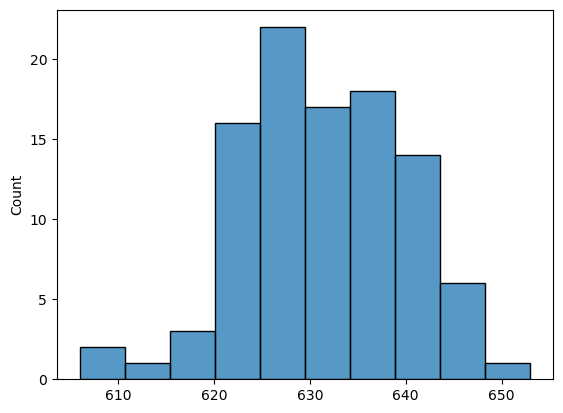

In [120]:
n_unique_list = []
for i in range(100):
    
    n_unique = np.unique(np.random.choice(range(1000), 1000)).size
    n_unique_list.append(n_unique)
    
sns.histplot(n_unique_list)

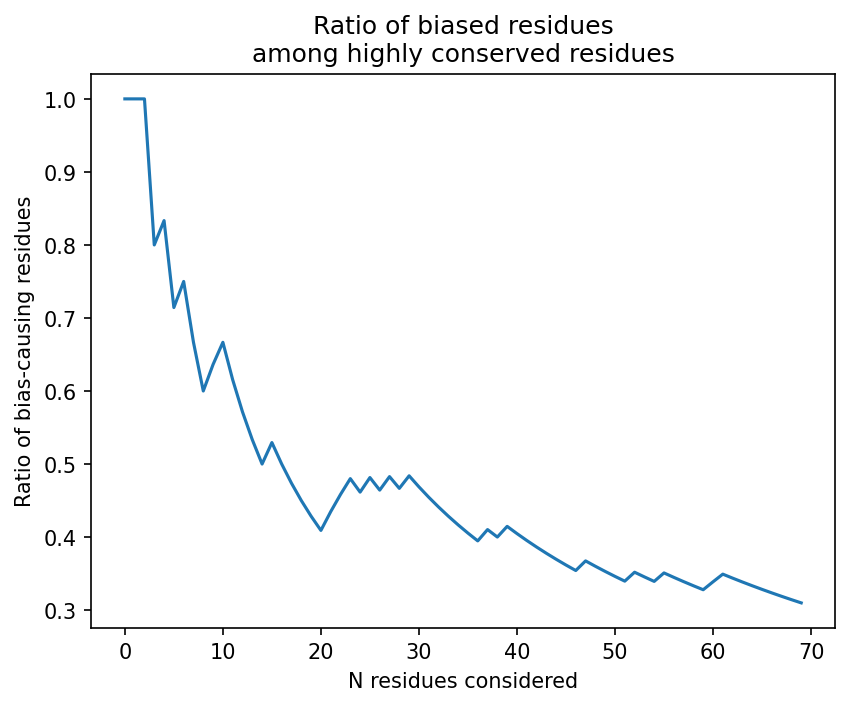

In [54]:
plt.figure(dpi=150)
plt.title('Ratio of biased residues\namong highly conserved residues')
plot_biased_percentage('class_a_score', n=70)

In [ ]:
# Get the top conserved residues of each profile
top_df = df.sort_values('class_a_score', ascending=False)[:15]

print('WT: ',' '.join(top_df[top_df.profile_lbl == 'wt'].position.values.astype(str)))

print('BIASED: ',' '.join(top_df[top_df.profile_lbl == 'biased'].position.values.astype(str)))

WT:  127 129 294 106 78 201 293
BIASED:  158 131 257 77 297 292 291 54


In [ ]:
top_df[['profile_lbl', 'position']].reset_index(drop=True)

,profile_lbl,position
0,biased,158
1,biased,131
2,biased,257
3,biased,77
4,wt,127
5,biased,297
6,wt,129
7,biased,292
8,wt,294
9,wt,106


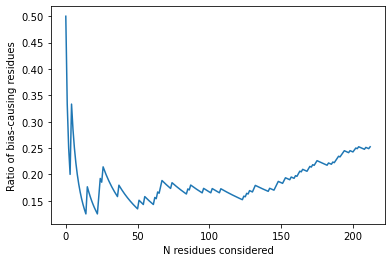

In [ ]:
plot_biased_percentage('alanin_score')

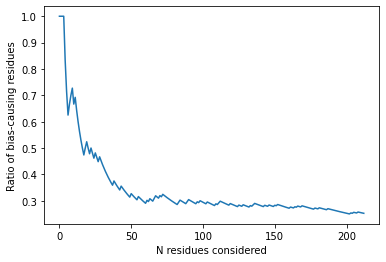

In [ ]:
plot_biased_percentage('lipidic_score')

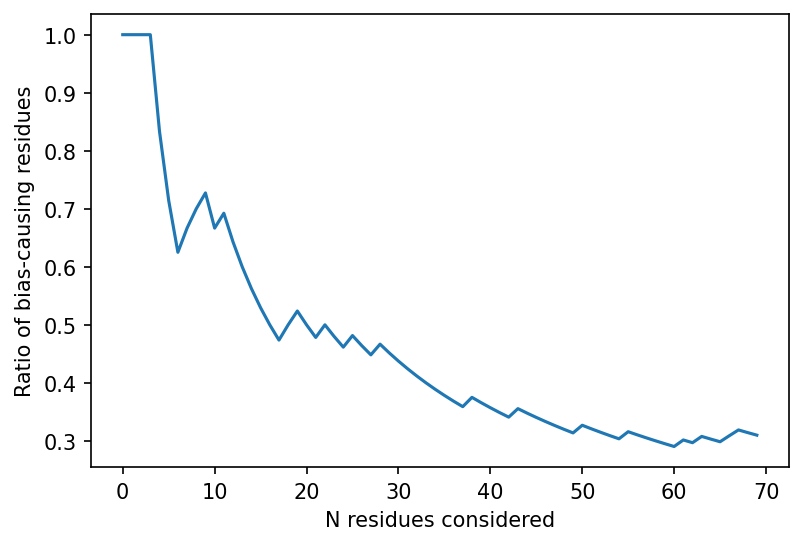

In [ ]:
plt.figure(dpi=150)
plot_biased_percentage('lipidic_score', n=70)

## Conservation-importance analysis

In [68]:
df

,position,gi_emax,gi_ec50,barr_emax,barr_ec50,profile_lbl,affected_gi,agg_label,affectation,class_a_score,alanin_score,lipidic_score,abs_coef,max_coef,sum_coef,min_coef
0,29,1.377266,-0.080726,1.453091,0.204319,wt,affected,wt-affected,0.589594,0.04546,0.013793,0.12263,0.000482,0.002194,0.024600,4.722614e-07
1,30,1.057022,-0.067825,1.336484,0.075457,wt,unaffected,wt-unaffected,0.341282,0.04888,0.062069,0.14737,0.000182,0.001481,0.008390,4.722614e-07
2,31,1.131454,0.147191,1.090715,-0.039388,wt,unaffected,wt-unaffected,0.159717,0.06530,0.082759,0.16487,0.000131,0.000677,0.002627,4.722614e-07
3,32,1.430271,-0.130197,1.454057,0.259686,wt,affected,wt-affected,0.625541,0.05891,0.082759,0.16710,0.000263,0.001648,0.010764,4.722614e-07
4,33,1.045174,-0.112751,0.945484,0.555771,wt,affected,wt-affected,0.070801,0.07116,0.124138,0.18397,0.000665,0.004072,0.039913,4.695187e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,315,1.284922,-0.033109,1.169000,0.396290,wt,affected,wt-affected,0.331273,0.12506,0.024138,0.24217,0.000444,0.001263,0.006664,3.924706e-06
210,316,1.215658,-0.287555,1.539277,0.171420,wt,affected,wt-affected,0.580800,0.09567,0.034483,0.21467,0.000333,0.001495,0.013644,2.028856e-06
211,317,1.364871,-0.056020,0.000000,8.942628,biased,affected,biased,1.064486,0.07678,0.013793,0.16433,0.000425,0.001391,0.011466,6.612635e-06
212,318,1.190868,-0.137452,0.790245,-0.354252,wt,affected,wt-affected,0.283598,0.05014,0.006897,0.12269,0.000222,0.001263,0.006207,7.260536e-07


In [69]:
sns.lineplot(data=counts_df[:], x=score, y='biased')
plt.xlabel('N residues considered')
plt.ylabel('Ratio of bias-causing residues')
plt.show()

NameError: name 'counts_df' is not defined

In [ ]:
def plot_importance_conservation(score):
    
    plt.figure(dpi=200, figsize=(10,6))
    
    for i, coef in enumerate(['abs_coef', 'max_coef', 'sum_coef', 'min_coef']):
        
        plt.subplot(2,2,i+1)
        sns.scatterplot(data=df, x=score, y=coef)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_importance_conservation('class_a_score')

In [ ]:
plot_importance_conservation('lipidic_score')

In [ ]:
plot_importance_conservation('alanin_score')